In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [13]:
Trump = pd.read_csv(r"C:\users\kevin\Trump.csv")
Trump.head()

,Unnamed: 0,created_time,text,source,favorite_count,retweet_count,hashtags,user_mentioned,url_used,media_used
0,0,2017-03-23 01:33:54,Spoke to U.K. Prime Minister Theresa May today...,Twitter for iPhone,54696,10042,[],[],False,False
1,1,2017-03-23 01:04:32,RT @mitchellvii: Trump always ends up being ri...,Twitter for iPhone,0,10307,[],[u'Bill Mitchell'],False,False
2,2,2017-03-23 01:03:18,RT @mitchellvii: EXACTLY AS I SAID - House Int...,Twitter for iPhone,0,7657,[],[u'Bill Mitchell'],False,False
3,3,2017-03-22 13:09:35,Big day for healthcare. Working hard!,Twitter for iPhone,75712,11211,[],[],False,False
4,4,2017-03-21 18:12:05,"Today on #NationalAgDay, we honor our great Am...",Twitter for iPhone,59871,13673,[u'NationalAgDay'],[],True,False


In [14]:
Trump.iloc[-1]

Unnamed: 0                                                     3237
created_time                                    2016-03-27 13:02:06
text              I am interviewed on This Week on @ABC this mor...
source                                          Twitter for Android
favorite_count                                                10054
retweet_count                                                  2460
hashtags                                                         []
user_mentioned                                        [u'ABC News']
url_used                                                      False
media_used                                                    False
Name: 3237, dtype: object

In [24]:
Trump["hashtag"] = [len(Trump["hashtags"].iloc[i])>2 for i in xrange(Trump.shape[0])]

Source_hashtag = pd.crosstab(index=Trump["hashtag"], columns=Trump["source"], margins = True)
Source_hashtag.index= ["No hashtag","have hashtag","All"]
Source_hashtag

source,Instagram,Media Studio,Periscope,Twitter Ads,Twitter Web Client,Twitter for Android,Twitter for iPad,Twitter for iPhone,All
No hashtag,2,0,0,1,158,1323,9,833,2326
have hashtag,0,1,1,0,107,95,13,695,912
All,2,1,1,1,265,1418,22,1528,3238


In [27]:
hashtag_tweet = Trump.groupby(by=["source","hashtag"]).count().reset_index()[["source","hashtag","text"]]
hashtag_tweet = pd.concat([hashtag_tweet[hashtag_tweet["source"] == "Twitter for Android"],hashtag_tweet[hashtag_tweet["source"] == "Twitter for iPhone"]])
hashtag_tweet

,source,hashtag,text
6,Twitter for Android,False,1323
7,Twitter for Android,True,95
10,Twitter for iPhone,False,833
11,Twitter for iPhone,True,695


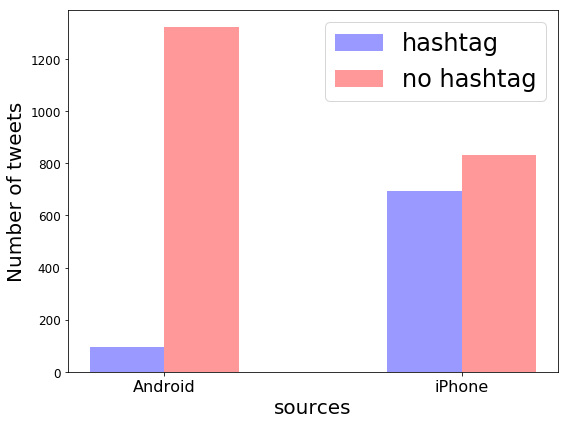

In [29]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 16

fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.25

number_hashtag = hashtag_tweet[hashtag_tweet["hashtag"]==True]["text"]
number_no =  hashtag_tweet[hashtag_tweet["hashtag"]!=True]["text"]

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, number_hashtag, bar_width,
                 alpha=opacity,
                 color='b',
                 label='hashtag')

rects2 = plt.bar(index + bar_width, number_no, bar_width,
                 alpha=opacity,
                 color='r',
                 label='no hashtag')

plt.xlabel('sources',size=20)
plt.ylabel('Number of tweets',size=20)
#plt.title('')
plt.xticks(index + bar_width / 2, ('Android', 'iPhone'))
plt.legend(prop={"size":24})

plt.tight_layout()
plt.show()
plt.savefig("hashtag.jpg")

In [34]:
Trump["quoted"] = ['"' in Trump["text"].iloc[i] for i in xrange(Trump.shape[0])]

Source_quoted = pd.crosstab(index=Trump["quoted"], columns=Trump["source"], margins = True)
Source_quoted.index= ["Not quoted","quoted","All"]
Source_quoted

source,Instagram,Media Studio,Periscope,Twitter Ads,Twitter Web Client,Twitter for Android,Twitter for iPad,Twitter for iPhone,All
Not quoted,2,1,1,1,246,1001,22,1477,2751
quoted,0,0,0,0,19,417,0,51,487
All,2,1,1,1,265,1418,22,1528,3238


In [35]:
quoted_tweet = Trump.groupby(by=["source","quoted"]).count().reset_index()[["source","quoted","text"]]
quoted_tweet = pd.concat([quoted_tweet[quoted_tweet["source"] == "Twitter for Android"],quoted_tweet[quoted_tweet["source"] == "Twitter for iPhone"]])
quoted_tweet

,source,quoted,text
6,Twitter for Android,False,1001
7,Twitter for Android,True,417
9,Twitter for iPhone,False,1477
10,Twitter for iPhone,True,51


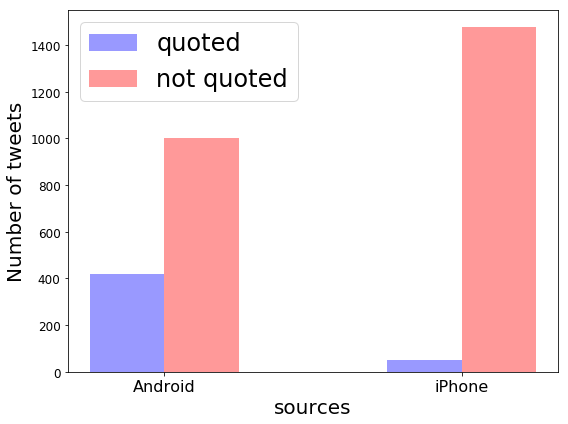

In [36]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.25

number_quoted = quoted_tweet[quoted_tweet["quoted"]==True]["text"]
number_not_quoted =  quoted_tweet[quoted_tweet["quoted"]!=True]["text"]

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, number_quoted, bar_width,
                 alpha=opacity,
                 color='b',
                 label='quoted')

rects2 = plt.bar(index + bar_width, number_not_quoted, bar_width,
                 alpha=opacity,
                 color='r',
                 label='not quoted')

plt.xlabel('sources',size=20)
plt.ylabel('Number of tweets',size=20)
#plt.title('')
plt.xticks(index + bar_width / 2, ('Android', 'iPhone'))
plt.legend(prop={"size":24})

plt.tight_layout()
plt.show()

In [38]:
Trump["at"] = [len(Trump["user_mentioned"].iloc[i])>2 for i in xrange(Trump.shape[0])]

Source_at = pd.crosstab(index=Trump["at"], columns=Trump["source"], margins = True)
Source_at.index= ["No at","at","All"]
Source_at

source,Instagram,Media Studio,Periscope,Twitter Ads,Twitter Web Client,Twitter for Android,Twitter for iPad,Twitter for iPhone,All
No at,2,1,1,1,170,914,16,1155,2260
at,0,0,0,0,95,504,6,373,978
All,2,1,1,1,265,1418,22,1528,3238


In [40]:
at_tweet = Trump.groupby(by=["source","at"]).count().reset_index()[["source","at","text"]]
at_tweet = pd.concat([at_tweet[at_tweet["source"] == "Twitter for Android"],at_tweet[at_tweet["source"] == "Twitter for iPhone"]])
at_tweet

,source,at,text
6,Twitter for Android,False,914
7,Twitter for Android,True,504
10,Twitter for iPhone,False,1155
11,Twitter for iPhone,True,373


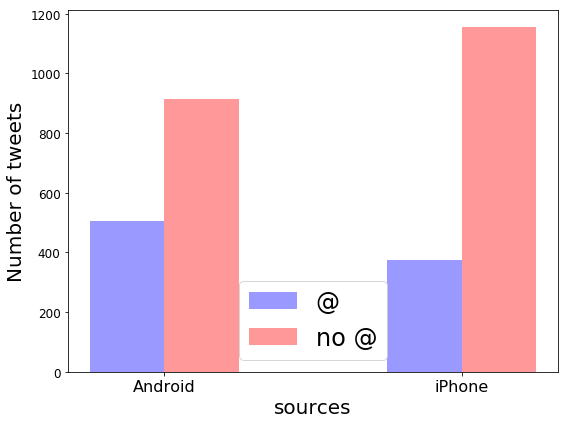

In [44]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.25

number_at = at_tweet[at_tweet["at"]==True]["text"]
number_no_at = at_tweet[at_tweet["at"]!=True]["text"]

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, number_at, bar_width,
                 alpha=opacity,
                 color='b',
                 label='@')

rects2 = plt.bar(index + bar_width, number_no_at, bar_width,
                 alpha=opacity,
                 color='r',
                 label='no @')

plt.xlabel('sources',size=20)
plt.ylabel('Number of tweets',size=20)
#plt.title('')
plt.xticks(index + bar_width / 2, ('Android', 'iPhone'))
plt.legend(prop={"size":24})

plt.tight_layout()
plt.show()

In [49]:
Trump["url_media"] = [Trump["url_used"].iloc[i] or Trump["media_used"].iloc[i] for i in xrange(Trump.shape[0])]

Source_link = pd.crosstab(index=Trump["url_media"], columns=Trump["source"], margins = True)
Source_link.index= ["No link","link","All"]
Source_link

source,Instagram,Media Studio,Periscope,Twitter Ads,Twitter Web Client,Twitter for Android,Twitter for iPad,Twitter for iPhone,All
No link,0,0,0,0,146,1339,5,410,1900
link,2,1,1,1,119,79,17,1118,1338
All,2,1,1,1,265,1418,22,1528,3238


In [55]:
link_tweet = Trump.groupby(by=["source","url_media"]).count().reset_index()[["source","url_media","text"]]
link_tweet = pd.concat([link_tweet[link_tweet["source"] == "Twitter for Android"],link_tweet[link_tweet["source"] == "Twitter for iPhone"]])
link_tweet

,source,url_media,text
6,Twitter for Android,False,1339
7,Twitter for Android,True,79
10,Twitter for iPhone,False,410
11,Twitter for iPhone,True,1118


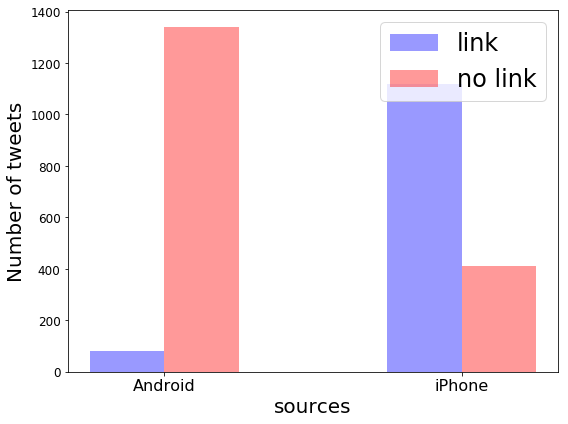

In [56]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.25

number_link = link_tweet[link_tweet["url_media"]==True]["text"]
number_no_link = link_tweet[link_tweet["url_media"]!=True]["text"]

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, number_link, bar_width,
                 alpha=opacity,
                 color='b',
                 label='link')

rects2 = plt.bar(index + bar_width, number_no_link, bar_width,
                 alpha=opacity,
                 color='r',
                 label='no link')

plt.xlabel('sources',size=20)
plt.ylabel('Number of tweets',size=20)
#plt.title('')
plt.xticks(index + bar_width / 2, ('Android', 'iPhone'))
plt.legend(prop={"size":24})

plt.tight_layout()
plt.show()

In [48]:
Trump

,Unnamed: 0,created_time,text,source,favorite_count,retweet_count,hashtags,user_mentioned,url_used,media_used,hashtag,quoted,at,url_media
0,0,2017-03-23 01:33:54,Spoke to U.K. Prime Minister Theresa May today...,Twitter for iPhone,54696,10042,[],[],False,False,False,False,False,False
1,1,2017-03-23 01:04:32,RT @mitchellvii: Trump always ends up being ri...,Twitter for iPhone,0,10307,[],[u'Bill Mitchell'],False,False,False,False,True,False
2,2,2017-03-23 01:03:18,RT @mitchellvii: EXACTLY AS I SAID - House Int...,Twitter for iPhone,0,7657,[],[u'Bill Mitchell'],False,False,False,False,True,False
3,3,2017-03-22 13:09:35,Big day for healthcare. Working hard!,Twitter for iPhone,75712,11211,[],[],False,False,False,False,False,False
4,4,2017-03-21 18:12:05,"Today on #NationalAgDay, we honor our great Am...",Twitter for iPhone,59871,13673,[u'NationalAgDay'],[],True,False,True,False,False,True
5,5,2017-03-21 17:33:23,Honored to sign S.442 today. With this legisla...,Twitter for iPhone,59658,13855,[],[u'NASA'],True,False,False,False,True,True
6,6,2017-03-21 17:02:31,Joined the @HouseGOP Conference this morning a...,Twitter for iPhone,31502,5558,"[u'PassTheBill', u'MAGA']",[u'House Republicans'],True,False,True,False,True,True
7,7,2017-03-21 02:18:20,"Thank you Louisville, Kentucky. Together, we w...",Twitter for iPhone,71497,14129,[],[],False,True,False,False,False,True
8,8,2017-03-20 23:03:36,"Thank you Louisville, Kentucky- on my way! #MA...",Twitter for iPhone,57913,10793,[u'MAGA'],[],False,True,True,False,False,True
9,9,2017-03-20 17:15:18,Congratulations Eric &amp; Lara. Very proud an...,Twitter for iPhone,96792,13227,[],[],True,False,False,False,False,True


<p>Trump's tweets from Android are more likely to quote others, are more likely to at(@) others. However, most of the hashtags(#) and links(url and media) are from iPhone.</p>

In [57]:
import nltk
from nltk.corpus import sentiwordnet as swn

def sentiment_of_word(s):
    '''
    Based on corpus "sentiwordnet", get the positive-negative score of a word.
    Input: s(string): a word for judgment.
    Output: score(float): the positive-negative score of the word.
    '''
    l = list(swn.senti_synsets(s))
    score = 0
    if len(l) > 0:
        for item in l:
            score += item.pos_score()
            score -= item.neg_score()
        score = score/len(l)
    return score

In [58]:
from nltk.corpus import stopwords

def sentiment_of_tweet(d):
    '''
    Based on sentiment_of_word, get the average score of a sentence or a paragraph (after removing stopwords).
    Input: d(string): a sentence or a paragraph.
    Output: average positive-negative score.
    '''
    stop = set(stopwords.words("english"))
    words = [word for word in d.lower().split() if word not in stop]
    score = 0
    for word in words:
        try:
            score += sentiment_of_word(word)
        except:
            pass
    return(score/len(words))

In [59]:
Trump["sentiment"] = [sentiment_of_tweet(text) for text in Trump["text"]]
Trump["negative"] = Trump["sentiment"]<0

In [60]:
Source_sentiment = pd.crosstab(index=Trump["negative"], columns=Trump["source"], margins = True)
Source_sentiment.index= ["positive","negative","All"]
Source_sentiment

source,Instagram,Media Studio,Periscope,Twitter Ads,Twitter Web Client,Twitter for Android,Twitter for iPad,Twitter for iPhone,All
positive,2,1,1,1,144,839,18,1123,2129
negative,0,0,0,0,121,579,4,405,1109
All,2,1,1,1,265,1418,22,1528,3238


In [61]:
#Chi_square test for Android and iPhone
import numpy as np
from scipy.stats import chisquare
obs = np.array([[Trump[(Trump["sentiment"]<0) & (Trump["source"] == "Twitter for Android")].shape[0],
                 Trump[(Trump["sentiment"]>=0) & (Trump["source"] == "Twitter for Android")].shape[0]],
                [Trump[(Trump["sentiment"]<0) & (Trump["source"] == "Twitter for iPhone")].shape[0],
                 Trump[(Trump["sentiment"]>=0) & (Trump["source"] == "Twitter for iPhone")].shape[0]]])
chisquare(obs,axis=None)

Power_divergenceResult(statistic=399.98234894772577, pvalue=2.233462745254962e-86)

<p>We use Obama's tweets for comparison.</p>

In [8]:
Obama = pd.read_csv(r"C:\users\kevin\Obama.csv")
Obama.head()

,Unnamed: 0,id,created_time,text,source,favorite_count,retweet_count,username
0,0,832675462325243906,2017-02-17 19:37:55,We asked. You answered. https://t.co/mAJvko6VqR,Twitter Web Client,101664,23627,BarackObama
1,1,831527113211645959,2017-02-14 15:34:47,"Happy Valentine’s Day, @michelleobama! Almost ...",Twitter Web Client,1057719,255894,BarackObama
2,2,823230505546117120,2017-01-22 18:07:02,I read letters like these every single day. It...,Twitter Web Client,232803,35037,BarackObama
3,3,822553543479541761,2017-01-20 21:17:01,RT @ObamaFoundation: Add your voice: https://t...,Twitter Web Client,0,48010,BarackObama
4,4,822550536469803009,2017-01-20 21:05:04,"In the meantime, I want to hear what you're th...",Twitter Web Client,236278,54259,BarackObama


In [9]:
Obama["sentiment"] = [sentiment_of_tweet(text) for text in Obama["text"]]
Obama["negative"] = Obama["sentiment"]<0
Obama.groupby(by="negative").count()["id"]

negative
False    2415
True      810
Name: id, dtype: int64

<p>For Obama, the proportion of negative tweets is about 25.1%. It is 26.5% for Trump's iPhone, and 40.8% for Trump's Android.</p>
<p>The proportion of Trump's iPhone is close to Obama's. However, Trump's Android is extremely high.</p>

<p>Also, for Trump, we want to see whether his tweets' ratio of negative change over times.</p>

In [62]:
import datetime
Trump["created_time"] = [datetime.datetime.strptime(Trump["created_time"].iloc[i],"%Y-%m-%d %H:%M:%S") for i in xrange(Trump.shape[0])]

Trump["year"] = [Trump["created_time"].iloc[i].year for i in xrange(Trump.shape[0])]
Trump["week"] = [Trump["created_time"].iloc[i].week for i in xrange(Trump.shape[0])]

In [63]:
def return_year(i):
    '''
    For 2017-01-01, the year is 2017 but the week is 52. That is because in system that day belongs to the last week in 2016.
    '''
    if Trump["created_time"].iloc[i].year == 2017 and Trump["created_time"].iloc[i].month == 1 and Trump["created_time"].iloc[i].day == 1:
        return 2016
    else:
        return Trump["created_time"].iloc[i].year
    
Trump["year"] = [return_year(i) for i in xrange(Trump.shape[0])]

In [72]:
Trump_week = Trump.groupby(by=["year","week","source"]).count().reset_index()[["year","week","text","source"]].merge(Trump.groupby(by=["year","week","source"]).sum().reset_index()[["year","week","negative","source"]],on=["year","week","source"])
Trump_week.head()

,year,week,text,source,negative
0,2016,12,7,Twitter for Android,0.0
1,2016,12,1,Twitter for iPhone,0.0
2,2016,13,5,Twitter Web Client,2.0
3,2016,13,32,Twitter for Android,12.0
4,2016,13,35,Twitter for iPhone,7.0


In [67]:
Trump_week_total = Trump_week.groupby(by=["year","week"]).sum()
Trump_week_total = Trump_week_total.reset_index()
Trump_week_total.shape

(53, 4)

In [68]:
Trump_week_android = Trump_week[Trump_week["source"] == "Twitter for Android"]
Trump_week_android.shape

(51, 5)

In [69]:
Trump_week_iphone = Trump_week[Trump_week["source"] == "Twitter for iPhone"]
Trump_week_iphone = pd.concat([Trump_week_iphone.iloc[0:35],pd.DataFrame({"year":2016,"week":46,"id":0,"source":"Twitter for iPhone","negative":0},index=[20]),Trump_week_iphone.iloc[35:]])
Trump_week_iphone.shape

(53, 6)

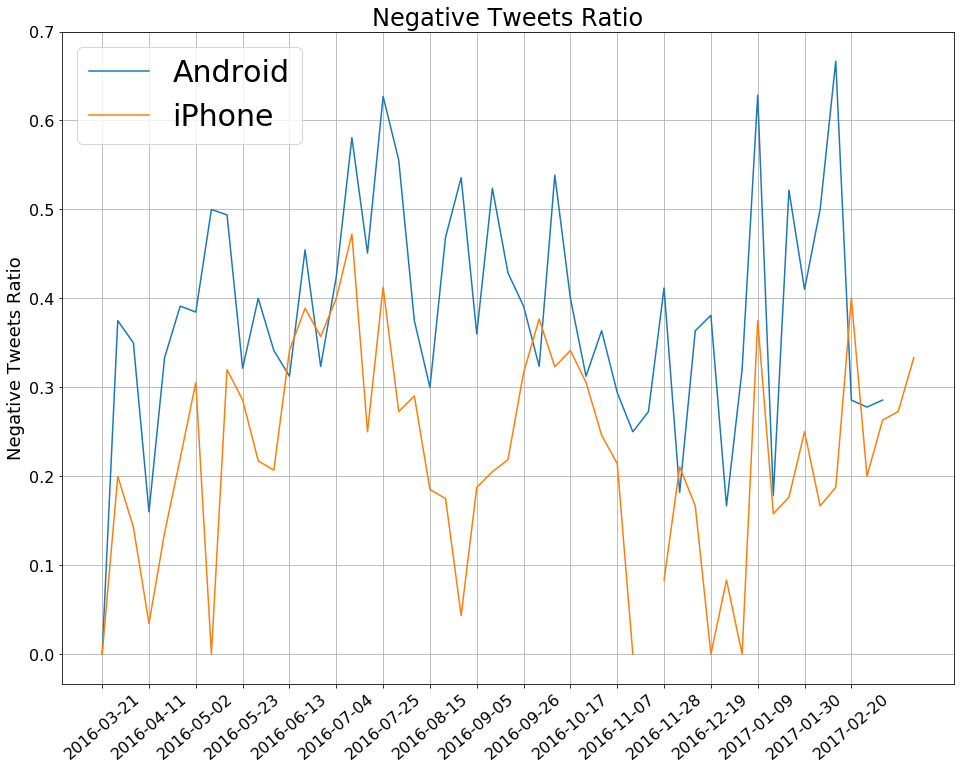

In [73]:
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['ytick.labelsize'] = 16
fig,ax = plt.subplots()

xticks = range(0,Trump_week_android.shape[0],3)
labels = [datetime.datetime.strptime("{} {} 1".format(Trump_week_total["year"].iloc[i], Trump_week_total["week"].iloc[i]), '%Y %W %w').date() for i in xrange(Trump_week_total.shape[0])]
xlabels = [labels[index] for index in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,rotation=40)

#week_total = list(Trump_week_total["negative"]/Trump_week_total["id"], label = "total)
week_android = list(Trump_week_android["negative"]/Trump_week_android["text"])
week_iphone = list(Trump_week_iphone["negative"]/Trump_week_iphone["text"])

#plt.plot(week_total)
plt.plot(week_android,label = "Android")
plt.plot(week_iphone, label = "iPhone")
plt.grid()
plt.legend(loc=2, prop={"size":30})
plt.title('Negative Tweets Ratio',size=24)
plt.ylabel("Negative Tweets Ratio",size=18)
plt.show()

<p>2016-07-02: Hillary Clinton's corruption scandal
<p>2016-09-09: Hillary's "Basket Of Deplorables"
<p>2016-10-07: Sexual misconduct accusations
<p>2017-01-09: Meryl Streep's speech
<p>2017-01-20: Inauguration
<p>2017-02-13: Michael Flynn resigned.